In [14]:
import numpy as np
import matplotlib.pyplot as plt
random_state = np.random.seed(42) 

## 데이터 만들기

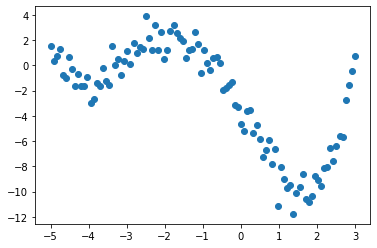

In [15]:
X=np.linspace(-5,3,100)
y=0.1*(X-3)*(X+3)*(X+1)*(X+5)+ np.random.normal(1,size=100)
plt.scatter(X,y)

## 파이프라이닝: 머신러닝 과정을 한번에 쭉

다항식을 추가한회귀를 하기 위해 필요한 과정
* 0) 입력 X.reshape(-1,1)
* 1) PolynomialFeatures로 변환
* 2) LinearRegression으로 학습
<br><br>
파이프라이닝이란 머신러닝하는 과정에서 여러개의 객체를 순서대로 실행해야할 경우, 그 과정을 하나로 묶어서 관리할 수 있는 객체
<br><br>
만드는 방법
* 1) 파이프라인 객체 만들기
* 2) 파이프라인 안에 순서대로 머신러닝에 사용될 객체 넣기
* 3) fit으로 학습


## 다항식이 들어간 회귀모형을 파이프라이닝으로 정의

In [30]:
from sklearn.pipeline import make_pipeline # 파이프라인 만들기 
from sklearn.preprocessing import PolynomialFeatures # 다항식이 추가되도록 데이터 변환
from sklearn.linear_model import LinearRegression # 선형회귀분석
from sklearn.model_selection import KFold, cross_validate #교차검증용 객체


# 파이프라이닝에 들어갈 재료
poly = PolynomialFeatures(degree=2) 
reg = LinearRegression() 

# 파이프라인이 없을때
# X_ = poly.fit_transform(X.reshape(-1,1))
# reg.fit(X_, y)

# 파이프라인 만들기
pipe = make_pipeline(poly, reg) #두가지 스텝을 동시에 수행

# 파이프라인에 넣어서 학습
# X: 첫번째 단계에서 들어가야할 데이터를 넣어준다
# y: 타겟변수(레이블)을 그대로 넣어준다
pipe.fit(X.reshape(-1,1),y) #학습

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

## 파이프라이닝과 CrossValidate 같이사용

In [31]:
# 파이프라인에 들어갈 재료 만들기
poly = PolynomialFeatures(degree=2)
reg = LinearRegression()

# 파이프라인 만들기
pipe = make_pipeline(poly, reg) #두가지 스텝을 동시에 수행

# 교차검증 객체
kfold = KFold(n_splits=5, shuffle=True) #데이터 쪼갤 방식
metrics = ['neg_mean_absolute_error','neg_mean_squared_error','r2'] #기록할 메트릭

# 교차검증 수행
result=cross_validate(X=X.reshape(-1,1),y=y,
                      estimator=pipe, # 파이프라인을 estimator로 두었음
                      scoring=metrics,
                      cv=kfold,
                      return_train_score=True                    
                     )


## cross_validate의 결과는 pandas로 변환하면 보기 좋다

In [33]:
# cross_validate의 결과물 : {키: [리스트]}
# pandas의 DataFrame으로 변환 가능
result

{'fit_time': array([0.00213933, 0.00150847, 0.00129461, 0.00094962, 0.00084257]),
 'score_time': array([0.00200844, 0.00153756, 0.00204873, 0.00079346, 0.00078225]),
 'test_neg_mean_absolute_error': array([-2.74444729, -2.29021611, -2.96663342, -2.18800522, -1.7867595 ]),
 'train_neg_mean_absolute_error': array([-2.1066083 , -2.31660165, -2.14070144, -2.39006295, -2.39623904]),
 'test_neg_mean_squared_error': array([-14.10171547,  -8.05982121, -13.50825326,  -7.08095975,
         -4.25485988]),
 'train_neg_mean_squared_error': array([-7.36898183, -8.63750751, -7.46793316, -8.94739254, -9.56522769]),
 'test_r2': array([0.17864808, 0.45749307, 0.35392232, 0.51847933, 0.63347369]),
 'train_r2': array([0.58076193, 0.51875535, 0.50869105, 0.48462537, 0.49405045])}

In [34]:
## 결과를 데이터프레임으로 변환
import pandas as pd
df=pd.DataFrame(result)
df

,fit_time,score_time,test_neg_mean_absolute_error,train_neg_mean_absolute_error,test_neg_mean_squared_error,train_neg_mean_squared_error,test_r2,train_r2
0,0.002139,0.002008,-2.744447,-2.106608,-14.101715,-7.368982,0.178648,0.580762
1,0.001508,0.001538,-2.290216,-2.316602,-8.059821,-8.637508,0.457493,0.518755
2,0.001295,0.002049,-2.966633,-2.140701,-13.508253,-7.467933,0.353922,0.508691
3,0.000950,0.000793,-2.188005,-2.390063,-7.080960,-8.947393,0.518479,0.484625
4,0.000843,0.000782,-1.786760,-2.396239,-4.254860,-9.565228,0.633474,0.494050


In [22]:
# 각각의 trial에 대한 평균값 계산
df.mean()

fit_time                         0.001364
score_time                       0.001325
test_neg_mean_absolute_error    -2.424166
train_neg_mean_absolute_error   -2.267167
test_neg_mean_squared_error     -9.786401
train_neg_mean_squared_error    -8.352632
test_r2                          0.392211
train_r2                         0.519978
dtype: float64

## 최적의 하이퍼패러미터 한번에 찾기: GridSearchCV

* 1) 파이프라인 재료 만들기
* 2) Pipeline을 이용해 파이프라인 만들기 (Pileline 함수 사용)
* 3) 하이퍼패러미터 범주지정
* 4) 교차검증 객체 지정
* 5) GridSearchCV를 이용해서 하이퍼패러미터 튜닝 실행
* 6) 결과분석 및 최적 하이퍼패러미터 도출

## GridSearchCV를 이용한 예시

* 하이퍼패러미터1: 다항식 1차식부터 19차식 까지 변경
* 파이프라인을 사용함
* 기존의 루프를 사용한 하이퍼패러미터 탐색방법에서 GridSearchCV라는 방법을 이용한 자동화

In [36]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression

from sklearn.pipeline import make_pipeline, Pipeline
import numpy as np

# 1) 파이프라인 재료 만들기
poly = PolynomialFeatures() #degree는 잡지 않는다.
reg = LinearRegression()

# 2) Pipeline을 이용한 파이프라인만들기
# pipe = make_pipeline(poly, reg)
pipe = Pipeline([('poly', poly), ('reg', reg)]) # 이름을 붙일때는 튜플형식('이름', estimator 객체)의 리스트로 순서대로 구현한다

# 3) 하이퍼패러미터 범주 지정
degrees = range(1,20) #1~19까지의 리스트
param_grid = {'poly__degree': degrees} # 탐색할 하이퍼패러미터의 범주를 딕셔너리 형태로 지정 (키: 파이프라인스텝이름__패러미터, 밸류: 리스트)

# 4) 교차검증 객체 지정
kfold = KFold(n_splits=5, shuffle=True) #데이터 쪼갤 방식

# 5) GridSearchCV를 이용하여 하이퍼패러미터 튜닝 자동화
grid_search = GridSearchCV(
    pipe, # 파이프라인
    param_grid, #탐색할 패러미터 범주
    cv=kfold, #교차검증 객체
    scoring='neg_mean_squared_error', #스코어
    return_train_score=True #훈련데이터 점수 반환 여부
)

# GridSearchCV 학습
grid_search.fit(X.reshape(-1,1), y)


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('reg', LinearRegression())]),
             param_grid={'poly__degree': range(1, 20)}, return_train_score=True,
             scoring='neg_mean_squared_error')

In [37]:
grid_search.cv_results_

{'mean_fit_time': array([0.0012959 , 0.00078115, 0.00067019, 0.00065703, 0.0006454 ,
        0.00063963, 0.00065179, 0.00064731, 0.00069985, 0.00066423,
        0.00068269, 0.00070057, 0.0007206 , 0.00072231, 0.00076656,
        0.00076671, 0.00074735, 0.00076604, 0.00080299]),
 'std_fit_time': array([3.40231536e-04, 1.46832292e-04, 2.49573125e-05, 6.95107558e-05,
        4.04213371e-05, 2.04481429e-05, 1.36215276e-05, 2.05742940e-05,
        6.05332706e-05, 1.91668372e-05, 2.59854815e-05, 3.62699156e-05,
        2.77064958e-05, 2.19622727e-05, 4.67196764e-05, 2.43202845e-05,
        2.14876390e-05, 1.05034141e-05, 3.84225429e-05]),
 'mean_score_time': array([0.00065832, 0.00034852, 0.00029993, 0.00033112, 0.00029535,
        0.00030255, 0.00030556, 0.0003057 , 0.0003314 , 0.00031428,
        0.00030813, 0.00031877, 0.00036459, 0.00033398, 0.00034757,
        0.00034451, 0.00034089, 0.00033946, 0.00035973]),
 'std_score_time': array([1.07544952e-04, 7.79978502e-05, 1.95735700e-05, 5.75

## GridSearchCV의 결과 분석

In [38]:
df = pd.DataFrame(grid_search.cv_results_)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001296,0.000340,0.000658,0.000108,1,{'poly__degree': 1},-15.324571,-5.979067,-11.396158,-8.644861,...,-9.653554,3.381471,19,-7.852558,-10.202041,-8.861510,-9.605927,-10.039628,-9.312333,0.864976
1,0.000781,0.000147,0.000349,0.000078,2,{'poly__degree': 2},-17.130384,-4.934227,-10.556170,-6.901806,...,-8.964091,4.542182,18,-6.436384,-9.385583,-7.986030,-8.977642,-9.416980,-8.440524,1.127674
2,0.000670,0.000025,0.000300,0.000020,3,{'poly__degree': 3},-9.820427,-2.669337,-7.506921,-3.376548,...,-5.779438,2.639154,17,-4.271917,-5.949694,-4.748725,-5.802324,-5.318616,-5.218255,0.632807
3,0.000657,0.000070,0.000331,0.000058,4,{'poly__degree': 4},-1.092362,-0.634781,-0.903824,-0.650480,...,-0.835168,0.172415,1,-0.688370,-0.803135,-0.740935,-0.805259,-0.737935,-0.755127,0.044207
4,0.000645,0.000040,0.000295,0.000013,5,{'poly__degree': 5},-1.095471,-0.645038,-0.903622,-0.661219,...,-0.845790,0.170943,2,-0.688005,-0.802386,-0.740726,-0.803249,-0.733989,-0.753671,0.044041
5,0.000640,0.000020,0.000303,0.000017,6,{'poly__degree': 6},-1.106746,-0.645043,-1.010120,-0.660409,...,-0.870252,0.186382,3,-0.687515,-0.802021,-0.726488,-0.803211,-0.733715,-0.750590,0.045295
6,0.000652,0.000014,0.000306,0.000008,7,{'poly__degree': 7},-1.109132,-0.645220,-1.009618,-0.662979,...,-0.871309,0.186335,4,-0.686375,-0.802019,-0.726194,-0.802235,-0.733396,-0.750044,0.045442
7,0.000647,0.000021,0.000306,0.000004,8,{'poly__degree': 8},-1.102138,-0.810087,-1.073116,-0.658271,...,-0.908124,0.165545,6,-0.686336,-0.761444,-0.701647,-0.787238,-0.728309,-0.732995,0.037238
8,0.000700,0.000061,0.000331,0.000063,9,{'poly__degree': 9},-1.095855,-0.756028,-1.027349,-0.709254,...,-0.902765,0.149862,5,-0.671976,-0.749776,-0.691217,-0.752681,-0.702141,-0.713558,0.032252
9,0.000664,0.000019,0.000314,0.000018,10,{'poly__degree': 10},-1.217833,-0.764076,-1.037502,-0.718184,...,-0.948482,0.184765,7,-0.664691,-0.749317,-0.689450,-0.751057,-0.692529,-0.709409,0.034671


In [39]:
df.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_poly__degree', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score', 'split0_train_score', 'split1_train_score',
       'split2_train_score', 'split3_train_score', 'split4_train_score',
       'mean_train_score', 'std_train_score'],
      dtype='object')

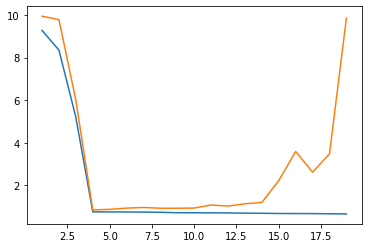

In [9]:
plt.plot(df['param_poly__degree'],-1*df['mean_train_score'])
plt.plot(df['param_poly__degree'],-1*df['mean_test_score'])

## 최적의 하이퍼패러미터

In [10]:
# Print the best hyperparameters and mean score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", -1*grid_search.best_score_b)

Best hyperparameters: {'poly__degree': 4}
Best score: 0.8470766870808244


## 최적의 하이퍼패러미터로 학습된 모형을 사용

In [44]:
best_model = grid_search.best_estimator_
best_model
# best_model.predict()

Pipeline(steps=[('poly', PolynomialFeatures(degree=4)),
                ('reg', LinearRegression())])

## 두개의 하이퍼패러미터를 이용한 예시

In [11]:
import warnings
warnings.filterwarnings('ignore')

In [45]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge

from sklearn.pipeline import make_pipeline, Pipeline
import numpy as np

# 1) 파이프라인 재료 만들기
poly = PolynomialFeatures() #degree는 잡지 않는다.
reg = Ridge()

# 2) 파이프라인 만들기
pipe = Pipeline(steps=[('poly', PolynomialFeatures()), ('ridge', Ridge())])

# 3) 하이퍼패러미터 범위 지정
degrees = range(1,20) # poly의 degree에 대한 범위
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10] # ridge의 alpha에 대한 범위
param_grid = {'poly__degree': degrees,
              'ridge__alpha': alphas}

# 4) 교차검증 객체 만들기
kfold = KFold(n_splits=5, shuffle=True) #데이터 쪼갤 방식

# 5) GridSearchCV 만들기
grid_search = GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error', return_train_score=True)

# 탐색시작
grid_search.fit(X.reshape(-1,1), y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('poly', PolynomialFeatures()),
                                       ('ridge', Ridge())]),
             param_grid={'poly__degree': range(1, 20),
                         'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [47]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_poly__degree,param_ridge__alpha,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.001582,0.000513,0.000687,0.000248,1,0.0001,"{'poly__degree': 1, 'ridge__alpha': 0.0001}",-11.935673,-6.456569,-8.314000,...,-9.823961,2.130097,114,-8.756285,-10.107274,-9.662060,-9.194973,-8.751931,-9.294505,0.527193
1,0.000718,0.000081,0.000323,0.000091,1,0.001,"{'poly__degree': 1, 'ridge__alpha': 0.001}",-11.935664,-6.456564,-8.314010,...,-9.823961,2.130094,113,-8.756285,-10.107274,-9.662060,-9.194973,-8.751931,-9.294505,0.527193
2,0.000893,0.000189,0.000368,0.000111,1,0.01,"{'poly__degree': 1, 'ridge__alpha': 0.01}",-11.935569,-6.456506,-8.314120,...,-9.823955,2.130069,112,-8.756285,-10.107274,-9.662060,-9.194973,-8.751931,-9.294505,0.527193
3,0.000987,0.000224,0.000397,0.000084,1,0.1,"{'poly__degree': 1, 'ridge__alpha': 0.1}",-11.934617,-6.455928,-8.315214,...,-9.823897,2.129821,111,-8.756286,-10.107275,-9.662060,-9.194974,-8.751931,-9.294505,0.527193
4,0.000737,0.000064,0.000317,0.000026,1,1,"{'poly__degree': 1, 'ridge__alpha': 1}",-11.925170,-6.450207,-8.326160,...,-9.823359,2.127365,110,-8.756333,-10.107320,-9.662096,-9.195013,-8.751977,-9.294548,0.527192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109,0.000875,0.000086,0.000413,0.000034,19,0.001,"{'poly__degree': 19, 'ridge__alpha': 0.001}",-1.588548,-0.945948,-1.051183,...,-1.413258,0.411074,75,-0.718911,-0.683887,-0.654752,-0.633424,-0.594703,-0.657135,0.042421
110,0.000810,0.000036,0.000419,0.000061,19,0.01,"{'poly__degree': 19, 'ridge__alpha': 0.01}",-1.616809,-0.939215,-1.055565,...,-1.455820,0.466132,76,-0.719868,-0.684294,-0.655045,-0.631663,-0.599230,-0.658020,0.041654
111,0.000819,0.000057,0.000411,0.000055,19,0.1,"{'poly__degree': 19, 'ridge__alpha': 0.1}",-1.956038,-0.901004,-1.079824,...,-1.490353,0.465126,79,-0.724310,-0.688722,-0.657259,-0.637869,-0.605453,-0.662723,0.040979
112,0.000809,0.000050,0.000394,0.000034,19,1,"{'poly__degree': 19, 'ridge__alpha': 1}",-1.391787,-0.783831,-1.208259,...,-1.290126,0.279973,72,-0.778173,-0.744802,-0.695397,-0.686182,-0.649666,-0.710844,0.045334


In [48]:
# Print the best hyperparameters and mean score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", -1*grid_search.best_score_)

Best hyperparameters: {'poly__degree': 4, 'ridge__alpha': 0.01}
Best score: 0.8554346484145388
